In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import os, shutil
import warnings
warnings.filterwarnings('ignore')

In [3]:
#train_dir = "D:/Projects/37008/LabelledRice/train/"   #Setting training directory
#validation_dir = "D:/Projects/37008/LabelledRice/validation/"   #Setting testing directory

    
train_dir = "D:/Projects/37008/RiceDiseaseDataset/train/"   #Setting training directory
validation_dir = "D:/Projects/37008/RiceDiseaseDataset/validation/"   #Setting testing directory


## Data Augmentation

rescale ----> rescaling factor. Defaults to None.

shear_range ----> 'Shear' means that the image will be distorted along an axis, mostly to create or rectify the perception angles.

horizontal_flip ----> Boolean. Randomly flip inputs horizontally.

vertical_flip ----> Boolean. Randomly flip inputs vertically.

zoom_range ----> Float or [lower, upper]. Range for random zoom

fill_mode: One of {"constant", "nearest", "reflect" or "wrap"}. Default is 'nearest'.

validation_split: Float. Fraction of images reserved for validation (strictly between 0 and 1).


In [9]:
train_dir = "D:/Projects/37008/LabelledRice/"   #Setting training directory
#validation_dir = "D:/Projects/37008/RiceDiseaseDataset/validation/"   #Setting testing directory

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(250, 250),
                                                    seed=505,                                                    
                                                    subset="training",
                                                   batch_size=20,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 3355 images belonging to 4 classes.


In [11]:
validation_datagen = ImageDataGenerator(rescale=1.0/255,
                                        validation_split=0.2,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')


validation_generator = validation_datagen.flow_from_directory(train_dir,
                                                             target_size=(250, 250),
                                                              seed=505,
                                                              subset='validation',                                                                                                                            
                                                             batch_size=20,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 669 images belonging to 4 classes.


In [12]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : BrownSpot
1 : Healthy
2 : Hispa
3 : LeafBlast


In [7]:
%%time

from keras.applications.densenet import DenseNet201

LEARNING_RATE = 0.001
NUM_CLASSES = 4

base_model1 = DenseNet201(weights="imagenet", include_top=False, input_shape=[331,331,3])
# base_model2 = InceptionResNetV2(weights='imagenet', include_top=False) 
                             
inputs = tf.keras.Input(shape=(331, 331, 3))

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
])

out_layer = data_augmentation(inputs)

out_layer = base_model1(out_layer)


conv_1x1 = tf.keras.layers.Conv2D(150, (1, 1), padding='same', activation='relu')(out_layer)
    
conv_3x3 = tf.keras.layers.Conv2D(100, (1, 1), padding='same', activation='relu')(out_layer)
conv_3x3 = tf.keras.layers.Conv2D(150, (3, 3), padding='same', activation='relu')(conv_3x3)

conv_5x5 = tf.keras.layers.Conv2D(50, (1, 1), padding='same', activation='relu')(out_layer)
conv_5x5 = tf.keras.layers.Conv2D(50, (4, 4), padding='same', activation='relu')(conv_5x5)
    
pool_proj = tf.keras.layers.MaxPool2D((2, 2), strides=(1, 1), padding='same')(out_layer) # 0.902
pool_proj = tf.keras.layers.Conv2D(80, (1, 1), padding='same', activation='relu')(pool_proj)


out_layer = tf.keras.layers.GlobalAveragePooling2D()(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
#out_layer = tf.keras.layers.Flatten()(out_layer)

out_layer = tf.keras.layers.Reshape((-1,80))(out_layer)
out_layer = tf.keras.layers.LSTM(50)(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)


#out_layer = tf.keras.layers.Flatten()(out_layer)
#out_layer = tf.keras.layers.GlobalAveragePooling2D()(out_layer)
out_layer = tf.keras.layers.Dense(units=50, activation='relu')(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
out_layer = tf.keras.layers.Dropout(rate=0.4)(out_layer)
pred = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(out_layer)
model = tf.keras.models.Model(inputs=inputs, outputs=pred)

for layer in base_model1.layers[:100]:
    layer.trainable = False

 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), # decay=learning_rate/EPOCHS
              loss='categorical_crossentropy',
              metrics=["accuracy"])

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,                    
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    epochs=10)

Epoch 1/10
167/167 [==============================] - 2749s 16s/step - loss: 1.6898 - accuracy: 0.3216 - val_loss: 1.3685 - val_accuracy: 0.3803
Epoch 2/10
167/167 [==============================] - 2806s 17s/step - loss: 1.3727 - accuracy: 0.4291 - val_loss: 1.3739 - val_accuracy: 0.4333
Epoch 3/10
167/167 [==============================] - 2871s 17s/step - loss: 1.2720 - accuracy: 0.4726 - val_loss: 1.2056 - val_accuracy: 0.4970
Epoch 4/10
167/167 [==============================] - 2875s 17s/step - loss: 1.0715 - accuracy: 0.5781 - val_loss: 1.5667 - val_accuracy: 0.4303
Epoch 5/10
167/167 [==============================] - 2649s 16s/step - loss: 0.9744 - accuracy: 0.6180 - val_loss: 1.0831 - val_accuracy: 0.5848
Epoch 6/10
167/167 [==============================] - 2751s 16s/step - loss: 0.8654 - accuracy: 0.6648 - val_loss: 1.1865 - val_accuracy: 0.5318
Epoch 7/10
167/167 [==============================] - 2965s 18s/step - loss: 0.8317 - accuracy: 0.6708 - val_loss: 1.1979 - val_ac

In [18]:
%%time

from keras.applications.densenet import DenseNet201

LEARNING_RATE = 0.001
NUM_CLASSES = 4

base_model1 = DenseNet201(weights="imagenet", include_top=False, input_shape=[250,250,3])
# base_model2 = InceptionResNetV2(weights='imagenet', include_top=False) 
                             
inputs = tf.keras.Input(shape=(250, 250, 3))

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
])

out_layer = data_augmentation(inputs)

out_layer = base_model1(out_layer)


conv_1x1 = tf.keras.layers.Conv2D(50, (1, 1), padding='same', activation='relu')(out_layer)
    
conv_3x3 = tf.keras.layers.Conv2D(50, (1, 1), padding='same', activation='relu')(out_layer)
conv_3x3 = tf.keras.layers.Conv2D(50, (3, 3), padding='same', activation='relu')(conv_3x3)

conv_5x5 = tf.keras.layers.Conv2D(25, (1, 1), padding='same', activation='relu')(out_layer)
conv_5x5 = tf.keras.layers.Conv2D(25, (4, 4), padding='same', activation='relu')(conv_5x5)
    
pool_proj = tf.keras.layers.MaxPool2D((2, 2), strides=(1, 1), padding='same')(out_layer) # 0.902
pool_proj = tf.keras.layers.Conv2D(50, (1, 1), padding='same', activation='relu')(pool_proj)


out_layer = tf.keras.layers.GlobalAveragePooling2D()(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
#out_layer = tf.keras.layers.Flatten()(out_layer)

out_layer = tf.keras.layers.Reshape((-1,10))(out_layer)
out_layer = tf.keras.layers.LSTM(25)(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)


#out_layer = tf.keras.layers.Flatten()(out_layer)
#out_layer = tf.keras.layers.GlobalAveragePooling2D()(out_layer)
out_layer = tf.keras.layers.Dense(units=25, activation='relu')(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
out_layer = tf.keras.layers.Dropout(rate=0.4)(out_layer)
pred = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(out_layer)
model = tf.keras.models.Model(inputs=inputs, outputs=pred)

for layer in base_model1.layers[:400]:
    layer.trainable = False

 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), # decay=learning_rate/EPOCHS
              loss='categorical_crossentropy',
              metrics=["accuracy"])

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,                    
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    epochs=33)

Epoch 1/33
167/167 [==============================] - 1001s 6s/step - loss: 1.3738 - accuracy: 0.4471 - val_loss: 1.3446 - val_accuracy: 0.3636
Epoch 2/33
167/167 [==============================] - 1003s 6s/step - loss: 1.0876 - accuracy: 0.5697 - val_loss: 1.0877 - val_accuracy: 0.5561
Epoch 3/33
167/167 [==============================] - 1004s 6s/step - loss: 0.9462 - accuracy: 0.6399 - val_loss: 1.5956 - val_accuracy: 0.5000
Epoch 4/33
167/167 [==============================] - 1033s 6s/step - loss: 0.8811 - accuracy: 0.6684 - val_loss: 0.9483 - val_accuracy: 0.6288
Epoch 5/33
167/167 [==============================] - 1046s 6s/step - loss: 0.8180 - accuracy: 0.6918 - val_loss: 1.2745 - val_accuracy: 0.5091
Epoch 6/33
167/167 [==============================] - 985s 6s/step - loss: 0.8026 - accuracy: 0.7100 - val_loss: 0.8649 - val_accuracy: 0.6909
Epoch 7/33
167/167 [==============================] - 1012s 6s/step - loss: 0.7797 - accuracy: 0.7133 - val_loss: 0.8883 - val_accuracy: 

KeyboardInterrupt: 

In [19]:
model.save("ricee.h5")

In [20]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.legend()
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.savefig(' accuracy.png')
plt.show()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.legend()
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig(' loss.png')
plt.show()

NameError: name 'history' is not defined

In [21]:
test_datagen = ImageDataGenerator(rescale=1.0/255,
                                        validation_split=0.2,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')


test_generator = test_datagen.flow_from_directory(train_dir,
                                                             target_size=(250, 250),
                                                              seed=505,
                                                              subset='validation',                                                                                                                            
                                                             batch_size=20,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 669 images belonging to 4 classes.


In [22]:
predictions = model.predict(test_generator)
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=32)

34/34 [==============================] - 96s 3s/step - loss: 0.6637 - accuracy: 0.7698


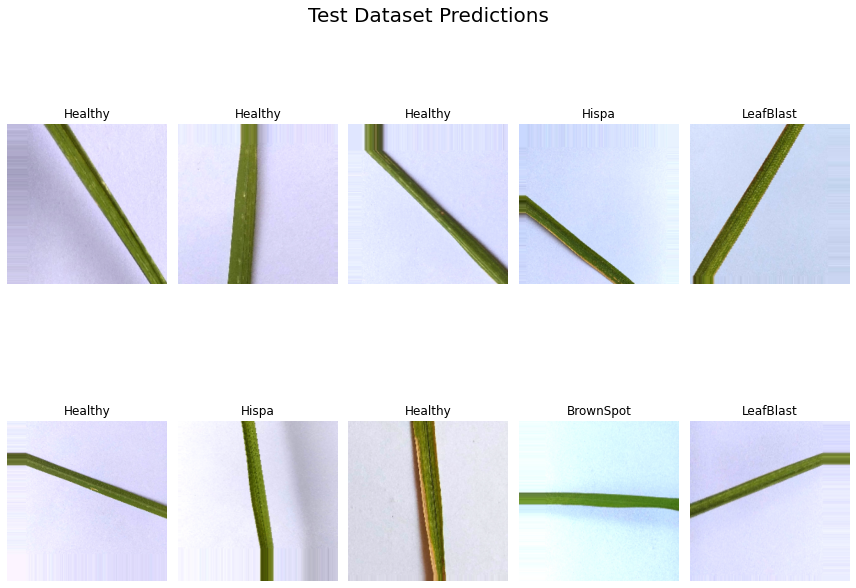

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [ ]:
%%time

from keras.applications.densenet import DenseNet201

LEARNING_RATE = 0.001
NUM_CLASSES = 4

base_model1 = DenseNet201(weights="imagenet", include_top=False, input_shape=[250,250,3])
# base_model2 = InceptionResNetV2(weights='imagenet', include_top=False) 
                             
inputs = tf.keras.Input(shape=(250, 250, 3))

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
])

out_layer = data_augmentation(inputs)

out_layer = base_model1(out_layer)


conv_1x1 = tf.keras.layers.Conv2D(150, (1, 1), padding='same', activation='relu')(out_layer)
    
conv_3x3 = tf.keras.layers.Conv2D(100, (1, 1), padding='same', activation='relu')(out_layer)
conv_3x3 = tf.keras.layers.Conv2D(150, (3, 3), padding='same', activation='relu')(conv_3x3)

conv_5x5 = tf.keras.layers.Conv2D(50, (1, 1), padding='same', activation='relu')(out_layer)
conv_5x5 = tf.keras.layers.Conv2D(50, (4, 4), padding='same', activation='relu')(conv_5x5)
    
pool_proj = tf.keras.layers.MaxPool2D((2, 2), strides=(1, 1), padding='same')(out_layer) # 0.902
pool_proj = tf.keras.layers.Conv2D(80, (1, 1), padding='same', activation='relu')(pool_proj)


out_layer = tf.keras.layers.GlobalAveragePooling2D()(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
#out_layer = tf.keras.layers.Flatten()(out_layer)

out_layer = tf.keras.layers.Reshape((-1,80))(out_layer)
out_layer = tf.keras.layers.LSTM(50)(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)


#out_layer = tf.keras.layers.Flatten()(out_layer)
#out_layer = tf.keras.layers.GlobalAveragePooling2D()(out_layer)
out_layer = tf.keras.layers.Dense(units=50, activation='relu')(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
out_layer = tf.keras.layers.Dropout(rate=0.4)(out_layer)
pred = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(out_layer)
model = tf.keras.models.Model(inputs=inputs, outputs=pred)

for layer in base_model1.layers[:400]:
    layer.trainable = False

 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), # decay=learning_rate/EPOCHS
              loss='categorical_crossentropy',
              metrics=["accuracy"])

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,                    
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    epochs=50)

Epoch 1/50
167/167 [==============================] - 968s 6s/step - loss: 1.3658 - accuracy: 0.4705 - val_loss: 1.1850 - val_accuracy: 0.5258
Epoch 2/50
167/167 [==============================] - 939s 6s/step - loss: 1.0540 - accuracy: 0.6156 - val_loss: 1.0020 - val_accuracy: 0.6197
Epoch 3/50
167/167 [==============================] - 946s 6s/step - loss: 0.9393 - accuracy: 0.6633 - val_loss: 0.9939 - val_accuracy: 0.6606
Epoch 4/50
167/167 [==============================] - 958s 6s/step - loss: 0.8617 - accuracy: 0.6891 - val_loss: 0.9005 - val_accuracy: 0.6682
Epoch 5/50
167/167 [==============================] - 950s 6s/step - loss: 0.8136 - accuracy: 0.7040 - val_loss: 0.8374 - val_accuracy: 0.7015
Epoch 6/50
167/167 [==============================] - 926s 6s/step - loss: 0.7812 - accuracy: 0.7142 - val_loss: 0.8921 - val_accuracy: 0.6848
Epoch 7/50
167/167 [==============================] - 951s 6s/step - loss: 0.7680 - accuracy: 0.7184 - val_loss: 0.9041 - val_accuracy: 0.6515

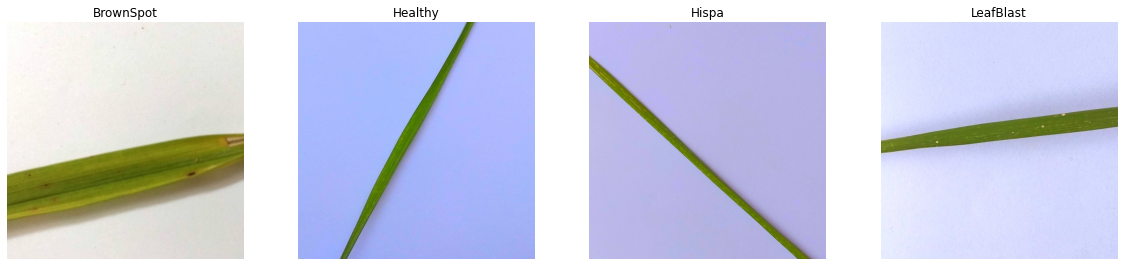

In [6]:
# Let's plot a few images
train_path = "D:/Projects/37008/LabelledRice/train/"
validation_path = "D:/Projects/37008/LabelledRice/validation/"
test_path = "D:/Projects/37008/LabelledRice/validation/"

image_categories = os.listdir("D:/Projects/37008/LabelledRice/train/")

def plot_images(image_categories):
    
    # Create a figure
    plt.figure(figsize=(20, 20))
    for i, cat in enumerate(image_categories):
        
        # Load images for the ith category
        image_path = train_path + '/' + cat
        images_in_folder = os.listdir(image_path)
        first_image_of_folder = images_in_folder[0]
        first_image_path = image_path + '/' + first_image_of_folder
        
        img = image.load_img(first_image_path)
        img_arr = image.img_to_array(img)/255.0
        
        
        # Create Subplot and plot the images
        plt.subplot(4, 4, i+1)
        plt.imshow(img_arr)
        plt.title(cat)
        plt.axis('off')
        
    plt.show()

# Call the function
plot_images(image_categories)

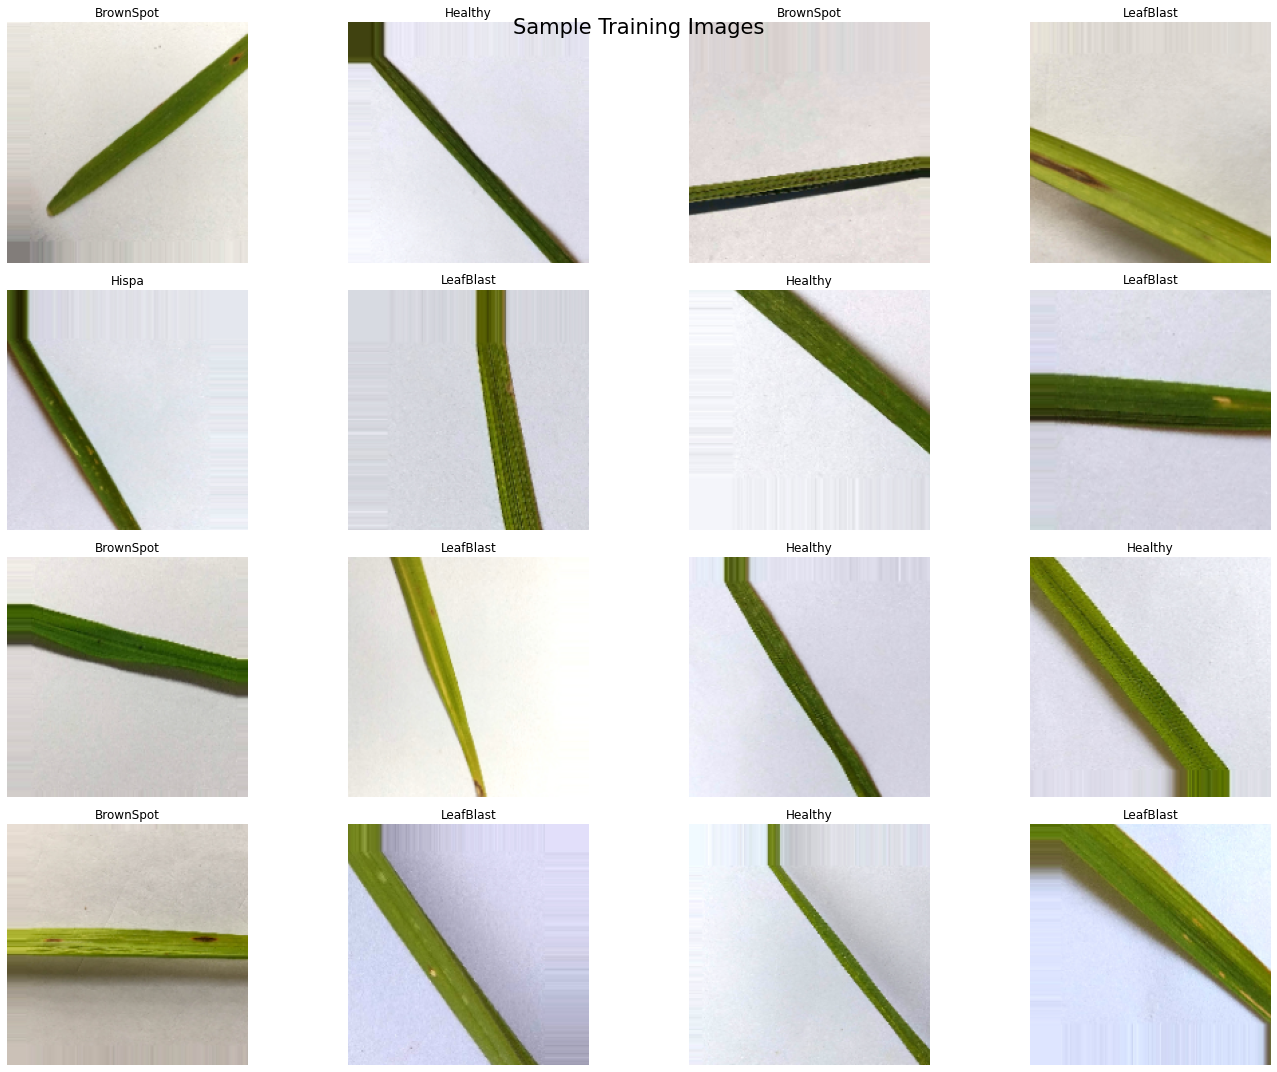

In [7]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
idx = 0

for i in range(4):
    for j in range(4):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()

plt.suptitle("Sample Training Images", fontsize=21)

plt.show()

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Parameters for our graph; we'll outpu images in a 4x4 configuration
nrows = 4
ncols = 4

# for iternating over images
pic_index = 0

In [9]:
train_BrownSpot_dir=r'D:\Projects\37008\LabelledRice\train\BrownSpot'
train_BrownSpot_names = os.listdir(train_BrownSpot_dir)
print(train_BrownSpot_names[:10])


train_Healthy_dir=r'D:\Projects\37008\LabelledRice\train\Healthy'
train_Healthy_names =  os.listdir(train_Healthy_dir)
print(train_Healthy_names[:10])


train_Hispa_dir=r'D:\Projects\37008\LabelledRice\train\BrownSpot'
train_Hispa_names = os.listdir(train_Hispa_dir)
print(train_Hispa_names[:10])


train_LeafBlast_dir=r'D:\Projects\37008\LabelledRice\train\BrownSpot'
train_LeafBlast_names =  os.listdir(train_LeafBlast_dir)
print(train_LeafBlast_names[:10])


['IMG_20190420_190715.jpg', 'IMG_20190420_190802.jpg', 'IMG_20190420_190812.jpg', 'IMG_20190420_190842.jpg', 'IMG_20190420_190858.jpg', 'IMG_20190420_190902.jpg', 'IMG_20190420_190908.jpg', 'IMG_20190420_190910.jpg', 'IMG_20190420_190913.jpg', 'IMG_20190420_190919.jpg']
['IMG_20190419_094251.jpg', 'IMG_20190419_094306.jpg', 'IMG_20190419_094316.jpg', 'IMG_20190419_094325.jpg', 'IMG_20190419_094744.jpg', 'IMG_20190419_094746.jpg', 'IMG_20190419_094750.jpg', 'IMG_20190419_094753.jpg', 'IMG_20190419_094756.jpg', 'IMG_20190419_094820.jpg']
['IMG_20190420_190715.jpg', 'IMG_20190420_190802.jpg', 'IMG_20190420_190812.jpg', 'IMG_20190420_190842.jpg', 'IMG_20190420_190858.jpg', 'IMG_20190420_190902.jpg', 'IMG_20190420_190908.jpg', 'IMG_20190420_190910.jpg', 'IMG_20190420_190913.jpg', 'IMG_20190420_190919.jpg']
['IMG_20190420_190715.jpg', 'IMG_20190420_190802.jpg', 'IMG_20190420_190812.jpg', 'IMG_20190420_190842.jpg', 'IMG_20190420_190858.jpg', 'IMG_20190420_190902.jpg', 'IMG_20190420_190908.jpg

## BrownSpot

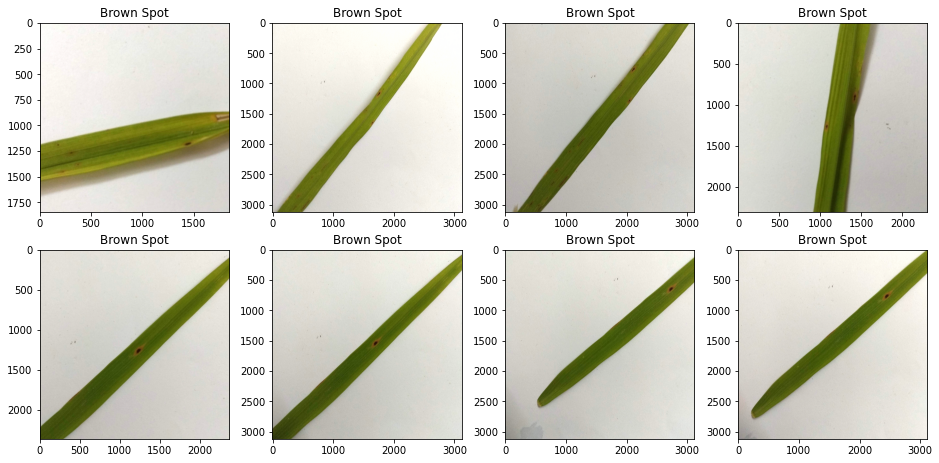

In [10]:
# Set up matplotlib fig, and size it to fit 4x4 pics

fig = plt.gcf()
fig.set_size_inches(ncols *4, nrows*4)
train_BrownSpot_dir=r'D:\Projects\37008\LabelledRice\train\BrownSpot'
pic_index += 8
next_BrownSpot_pix = [os.path.join(train_BrownSpot_dir, fname)
                for fname in train_BrownSpot_names[pic_index-8:pic_index]]
for i, img_path in enumerate(next_BrownSpot_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows,ncols,i +1)
  #sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.title("Brown Spot")

plt.show()

## Healthy

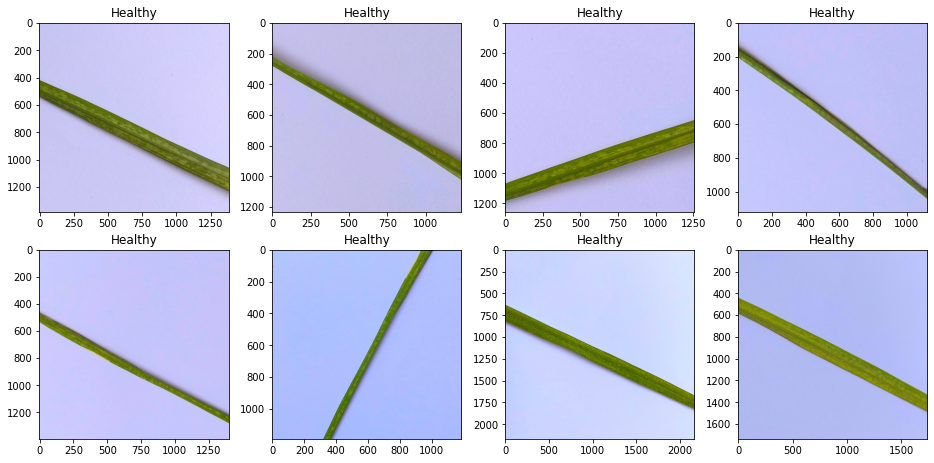

In [11]:
# Set up matplotlib fig, and size it to fit 4x4 pics

fig = plt.gcf()
fig.set_size_inches(ncols *4, nrows*4)

pic_index += 8
next_Healthy_pix = [os.path.join(train_Healthy_dir, fname)
                for fname in train_Healthy_names[pic_index-8:pic_index]]


for i, img_path in enumerate(next_Healthy_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows,ncols,i +1)
  #sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.title("Healthy")

plt.show()

# Hispa

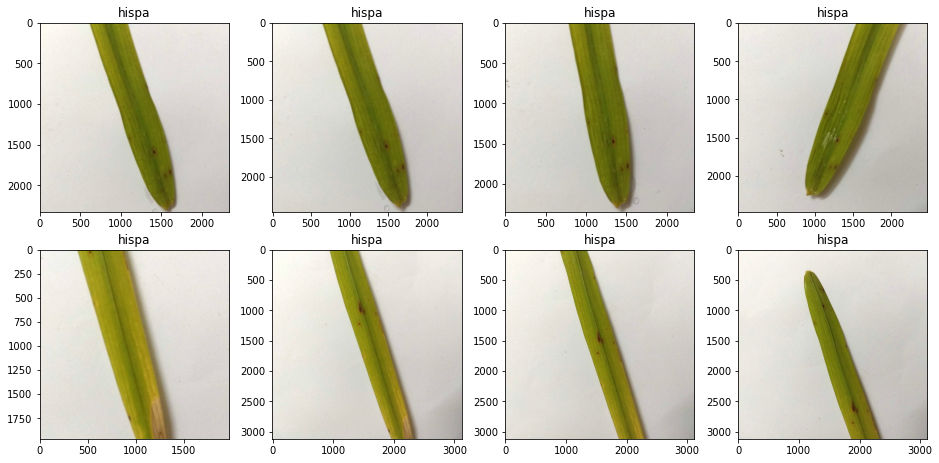

In [12]:
# Set up matplotlib fig, and size it to fit 4x4 pics

fig = plt.gcf()
fig.set_size_inches(ncols *4, nrows*4)

pic_index += 8

next_Hispa_pix = [os.path.join(train_Hispa_dir, fname)
                for fname in train_Hispa_names[pic_index-8:pic_index]]


for i, img_path in enumerate(next_Hispa_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows,ncols,i +1)
  #sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.title('hispa')

plt.show()

# LeafBlast

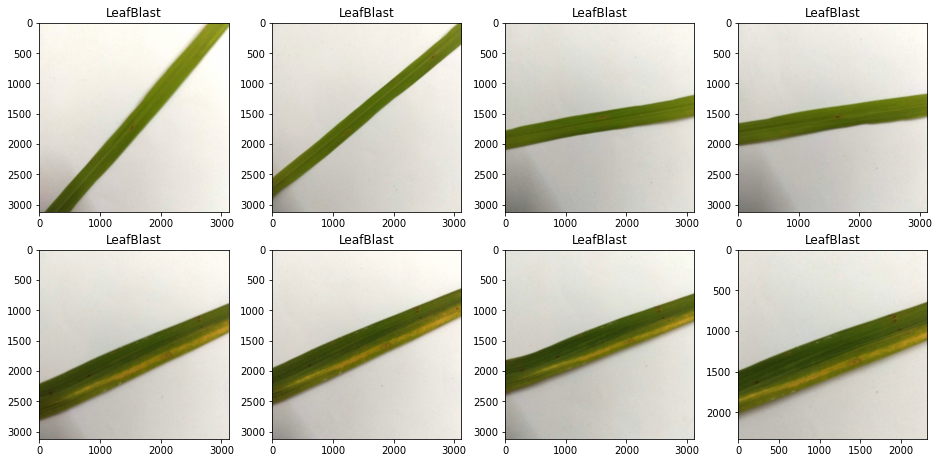

In [13]:
# Set up matplotlib fig, and size it to fit 4x4 pics

fig = plt.gcf()
fig.set_size_inches(ncols *4, nrows*4)

pic_index += 8

next_LeafBlast_pix = [os.path.join(train_LeafBlast_dir, fname)
                for fname in train_LeafBlast_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_LeafBlast_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows,ncols,i +1)
  #sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.title('LeafBlast')

plt.show()

In [6]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,log = {}):
    if(log.get('accuracy')> 0.99):
      if(log.get('val_accuracy')>0.99):
        print("\n Reached 99% Accuracy for both train and val.")
        self.model.stop_training = True

callbacks = MyCallback()

## Base Model:

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',input_shape = (224,224,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32,activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16,activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4,activation = 'softmax')

],    name = 'Conv2D_Model')

model.summary()

Model: "Conv2D_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)      

In [8]:
LEARNING_RATE = 0.01 #@param {type:"number"}

model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [9]:
%%time

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=5,
        validation_data=validation_generator,
        callbacks = [callbacks],
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/5
69/69 [==============================] - 393s 6s/step - loss: 1.3240 - accuracy: 0.4134 - val_loss: 1.2860 - val_accuracy: 0.4295
Epoch 2/5
69/69 [==============================] - 301s 4s/step - loss: 1.2657 - accuracy: 0.4432 - val_loss: 1.3342 - val_accuracy: 0.4339
Epoch 3/5
69/69 [==============================] - 287s 4s/step - loss: 1.2316 - accuracy: 0.4688 - val_loss: 1.3056 - val_accuracy: 0.4330
Epoch 4/5
69/69 [==============================] - 275s 4s/step - loss: 1.1677 - accuracy: 0.5032 - val_loss: 1.4341 - val_accuracy: 0.4295
Epoch 5/5
69/69 [==============================] - 304s 4s/step - loss: 1.1124 - accuracy: 0.5325 - val_loss: 1.5592 - val_accuracy: 0.3598
Wall time: 26min 3s


In [10]:
test_dataset = 'D:/Projects/37008/LabelledRice/validation/'

test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=32,
                                                 target_size = (224, 224),
                                                 class_mode='categorical')

Found 1141 images belonging to 4 classes.


In [11]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=32)

36/36 [==============================] - 66s 2s/step - loss: 1.5638 - accuracy: 0.3602


In [12]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     1.5637716054916382
Test Accuracy: 0.3602103292942047


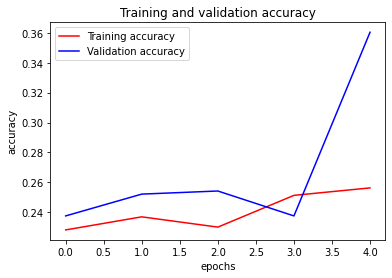

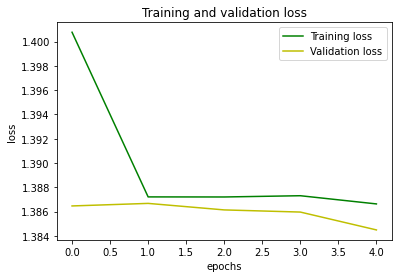

In [18]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.legend()
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.savefig(' accuracy.png')
plt.show()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.legend()
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig(' loss.png')
plt.show()

In [14]:
%%time

from tensorflow.keras import models
from keras.models import Sequential, load_model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.regularizers import l2

reg2=reg2=l2(1e-4)     
initializer = tf.keras.initializers.GlorotNormal()


model = models.Sequential()
model.add(Conv2D(filters=32,kernel_size=(5,5),strides=1,padding='same',input_shape=(224,224,3)))
#model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Conv2D(filters=64,kernel_size=(3,3),strides=2, padding='same'))
model.add(Activation('relu'))
#model.add(Dropout(0.1))

model.add(Conv2D(filters=64,kernel_size=(3,3),strides=1,padding='same'))
#model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Conv2D(filters=64,kernel_size=(5,5),strides=2, padding='same'))
model.add(Activation('relu'))
#model.add(Dropout(0.1))

model.add(Conv2D(filters=64,kernel_size=(3,3),strides=1,padding='same'))
#model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Conv2D(filters=64,kernel_size=(3,3),strides=1,padding='same'))
#model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Conv2D(filters=64,kernel_size=(3,3),strides=1,padding='same'))
model.add(BatchNormalization())
#model.add(Dropout(0.1))
model.add(Activation('relu'))


model.add(Conv2D(filters=64,kernel_size=(5,5),strides=1,padding='same'))
#model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),strides=1,padding='same'))
model.add(BatchNormalization())
#model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Reshape((-1, 64)))

model.add(LSTM(64,activation='relu'))

#model.add(MaxPooling2D(pool_size=(2, 2),strides=1))
model.add(Dense(32,Activation('relu'),kernel_initializer=initializer))

model.add(Flatten())

model.add(Dense(4, activation='softmax'))


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])

#model.summary()

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,                    
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    epochs=50)

Epoch 1/50
69/69 [==============================] - 366s 5s/step - loss: nan - acc: 0.4244 - val_loss: nan - val_acc: 0.1777
Epoch 2/50
19/69 [=======>......................] - ETA: 3:28 - loss: nan - acc: 0.1332

KeyboardInterrupt: 

# VGG16 layout

In [31]:
%%time

from tensorflow.keras import models
from keras.models import Sequential, load_model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.regularizers import l2

reg2=reg2=l2(1e-4)     
initializer = tf.keras.initializers.GlorotNormal()


model = models.Sequential()

model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding='same', activation='relu'))

model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same', activation='relu'))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu'))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))

model.add(Conv2D(filters=128, kernel_size=(3,3),padding='same', activation='relu'))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3),padding='same', activation='relu'))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))

model.add(Conv2D(filters=256, kernel_size=(3,3),padding='same', activation='relu'))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
                
#model.add(Flatten())

model.add(Reshape((-1, 256)))

model.add(LSTM(256,activation='relu'))

#model.add(MaxPooling2D(pool_size=(2, 2),strides=1))
model.add(Flatten())


model.add(Dense(units=596,activation="relu"))

model.add(Dense(units=596,activation="relu"))

model.add(Dense(units=4, activation="softmax"))



model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])

#model.summary()


Wall time: 413 ms


In [32]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, 
                             mode='auto', period=1)


early = EarlyStopping(monitor='val_acc', min_delta=0, patience=7, verbose=1, mode='auto')

In [33]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,                    
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    epochs=10,callbacks=[checkpoint,early])

Epoch 1/10
69/69 [==============================] - ETA: 0s - loss: 1.3036 - acc: 0.4487
Epoch 1: val_acc improved from -inf to 0.42679, saving model to vgg16_1.h5
69/69 [==============================] - 758s 11s/step - loss: 1.3036 - acc: 0.4487 - val_loss: 1.3081 - val_acc: 0.4268


KeyboardInterrupt: 

In [6]:
%%time

from tensorflow.keras import models
from keras.models import Sequential, load_model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.regularizers import l2


reg2=reg2=l2(1e-4)     
initializer = tf.keras.initializers.GlorotNormal()


model = models.Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',input_shape=(224,224,3)))
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu', padding='same'))
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(1,1),strides=(2,2)))


model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu', padding='same'))
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(1,1),strides=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),kernel_regularizer=reg2,activation='relu', padding='same'))
model.add(Conv2D(filters=64,kernel_size=(3,3),kernel_regularizer=reg2,activation='relu', padding='same'))
model.add(Conv2D(filters=64,kernel_size=(3,3),kernel_regularizer=reg2,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),kernel_regularizer=reg2,activation='relu', padding='same'))
model.add(Conv2D(filters=64,kernel_size=(3,3),kernel_regularizer=reg2,activation='relu', padding='same'))
model.add(Conv2D(filters=64,kernel_size=(3,3),kernel_regularizer=reg2,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(2,2),kernel_regularizer=reg2,padding='same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=(2,2),kernel_regularizer=reg2,padding='same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=(2,2),kernel_regularizer=reg2,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(Conv2D(filters=128,kernel_size=(3,3),kernel_regularizer=reg2,padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=(3,3),kernel_regularizer=reg2,padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=(3,3),kernel_regularizer=reg2,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128,kernel_size=(3,3),kernel_regularizer=reg2,padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=(3,3),kernel_regularizer=reg2,padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=(3,3),kernel_regularizer=reg2,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

#model.add(Flatten())
model.add(Reshape((-1, 128)))
model.add(LSTM(128,activation='relu'))

model.add(Flatten())

model.add(Dense(64,Activation('relu'),kernel_initializer=initializer))
model.add(BatchNormalization())


model.add(Dense(4, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])

#model.summary()


from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, 
                             mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')


history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,                    
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    epochs=20,callbacks=[checkpoint,early])

Epoch 1/20
69/69 [==============================] - ETA: 0s - loss: 1.4900 - acc: 0.4271
Epoch 1: val_acc improved from -inf to 0.42679, saving model to vgg16_1.h5
69/69 [==============================] - 465s 7s/step - loss: 1.4900 - acc: 0.4271 - val_loss: 1.4593 - val_acc: 0.4268
Epoch 2/20
69/69 [==============================] - ETA: 0s - loss: 1.3895 - acc: 0.4170
Epoch 2: val_acc did not improve from 0.42679
69/69 [==============================] - 443s 6s/step - loss: 1.3895 - acc: 0.4170 - val_loss: 1.4528 - val_acc: 0.3705
Epoch 3/20
69/69 [==============================] - ETA: 0s - loss: 1.2757 - acc: 0.5270
Epoch 3: val_acc did not improve from 0.42679
69/69 [==============================] - 441s 6s/step - loss: 1.2757 - acc: 0.5270 - val_loss: 1.3784 - val_acc: 0.3938
Epoch 4/20
69/69 [==============================] - ETA: 0s - loss: 1.2114 - acc: 0.5577
Epoch 4: val_acc did not improve from 0.42679
69/69 [==============================] - 439s 6s/step - loss: 1.2114 - 

KeyboardInterrupt: 

In [ ]:
%%time

from tensorflow.keras import models
from keras.models import Sequential, load_model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.regularizers import l2


reg2=reg2=l2(1e-4)     
initializer = tf.keras.initializers.GlorotNormal()


model = models.Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',input_shape=(224,224,3)))
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu', padding='same'))
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(1,1),strides=(2,2)))


model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu', padding='same'))
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),kernel_regularizer=reg2,activation='relu', padding='same'))
model.add(Conv2D(filters=64,kernel_size=(3,3),kernel_regularizer=reg2,activation='relu', padding='same'))
model.add(Conv2D(filters=64,kernel_size=(3,3),kernel_regularizer=reg2,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),kernel_regularizer=reg2,activation='relu', padding='same'))
model.add(Conv2D(filters=64,kernel_size=(3,3),kernel_regularizer=reg2,activation='relu', padding='same'))
model.add(Conv2D(filters=64,kernel_size=(3,3),kernel_regularizer=reg2,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(2,2),kernel_regularizer=reg2,padding='same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=(2,2),kernel_regularizer=reg2,padding='same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=(2,2),kernel_regularizer=reg2,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(Conv2D(filters=128,kernel_size=(3,3),kernel_regularizer=reg2,padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=(3,3),kernel_regularizer=reg2,padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=(3,3),kernel_regularizer=reg2,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128,kernel_size=(3,3),kernel_regularizer=reg2,padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=(3,3),kernel_regularizer=reg2,padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=(3,3),kernel_regularizer=reg2,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

#model.add(Flatten())
model.add(Reshape((-1, 128)))
model.add(LSTM(128,activation='relu'))

model.add(Flatten())

model.add(Dense(64,Activation('relu'),kernel_initializer=initializer))
model.add(BatchNormalization())


model.add(Dense(4, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['acc'])

#model.summary()


from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, 
                             mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')


history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,                    
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    epochs=20,callbacks=[checkpoint,early])

In [ ]:
filters_1x1=300,
filters_3x3_reduce=200,
filters_3x3=320,
filters_5x5_reduce=100,
filters_5x5=100

T1

In [14]:
from keras.applications.densenet import DenseNet201

LEARNING_RATE = 0.001
EPOCHS = 30
NUM_CLASSES = 4

base_model1 = DenseNet201(weights="imagenet", include_top=False, input_shape=[180,180,3])
# base_model2 = InceptionResNetV2(weights='imagenet', include_top=False) 
                             
inputs = tf.keras.Input(shape=(180, 180, 3))

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
])


out_layer = data_augmentation(inputs)

out_layer = base_model1(out_layer)



conv_1x1 = tf.keras.layers.Conv2D(300, (1, 1), padding='same', activation='relu')(out_layer)
    
conv_3x3 = tf.keras.layers.Conv2D(200, (1, 1), padding='same', activation='relu')(out_layer)
conv_3x3 = tf.keras.layers.Conv2D(320, (3, 3), padding='same', activation='relu')(conv_3x3)

conv_5x5 = tf.keras.layers.Conv2D(100, (1, 1), padding='same', activation='relu')(out_layer)
conv_5x5 = tf.keras.layers.Conv2D(100, (4, 4), padding='same', activation='relu')(conv_5x5)
    
pool_proj = tf.keras.layers.MaxPool2D((2, 2), strides=(1, 1), padding='same')(out_layer) # 0.902
pool_proj = tf.keras.layers.Conv2D(80, (1, 1), padding='same', activation='relu')(pool_proj)



out_layer = tf.keras.layers.GlobalAveragePooling2D()(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
out_layer = tf.keras.layers.Dense(units=100, activation='relu')(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
out_layer = tf.keras.layers.Dropout(rate=0.4)(out_layer)

out_layer = tf.keras.layers.Reshape((-1,100))(out_layer)
out_layer = tf.keras.layers.LSTM(100)(out_layer)

out_layer = tf.keras.layers.Dense(100)(out_layer)

pred = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(out_layer)
model = tf.keras.models.Model(inputs=inputs, outputs=pred)

for layer in base_model1.layers[:410]:
    layer.trainable = False

 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), # decay=learning_rate/EPOCHS
              loss='categorical_crossentropy',
              metrics=["accuracy"])


history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,                    
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    epochs=20)

Epoch 1/10
84/84 [==============================] - 499s 6s/step - loss: 1.0125 - accuracy: 0.6056 - val_loss: 2.5010 - val_accuracy: 0.4211
Epoch 2/10
84/84 [==============================] - 448s 5s/step - loss: 0.8493 - accuracy: 0.6719 - val_loss: 1.4625 - val_accuracy: 0.5033
Epoch 3/10
84/84 [==============================] - 439s 5s/step - loss: 0.7756 - accuracy: 0.7047 - val_loss: 1.7152 - val_accuracy: 0.4638
Epoch 4/10
84/84 [==============================] - 443s 5s/step - loss: 0.7503 - accuracy: 0.7073 - val_loss: 1.5956 - val_accuracy: 0.4786
Epoch 5/10
84/84 [==============================] - 440s 5s/step - loss: 0.7347 - accuracy: 0.7188 - val_loss: 1.6306 - val_accuracy: 0.4293
Epoch 6/10
84/84 [==============================] - 429s 5s/step - loss: 0.7081 - accuracy: 0.7244 - val_loss: 1.7613 - val_accuracy: 0.4885
Epoch 7/10
84/84 [==============================] - 433s 5s/step - loss: 0.6637 - accuracy: 0.7348 - val_loss: 1.6988 - val_accuracy: 0.4622
Epoch 8/10
84

T2

In [15]:
from keras.applications.densenet import DenseNet201

LEARNING_RATE = 0.001
NUM_CLASSES = 4

base_model1 = DenseNet201(weights="imagenet", include_top=False, input_shape=[180,180,3])
# base_model2 = InceptionResNetV2(weights='imagenet', include_top=False) 
                             
inputs = tf.keras.Input(shape=(180, 180, 3))

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
])


out_layer = data_augmentation(inputs)

out_layer = base_model1(out_layer)



conv_1x1 = tf.keras.layers.Conv2D(300, (1, 1), padding='same', activation='relu')(out_layer)
    
conv_3x3 = tf.keras.layers.Conv2D(200, (1, 1), padding='same', activation='relu')(out_layer)
conv_3x3 = tf.keras.layers.Conv2D(320, (3, 3), padding='same', activation='relu')(conv_3x3)

conv_5x5 = tf.keras.layers.Conv2D(100, (1, 1), padding='same', activation='relu')(out_layer)
conv_5x5 = tf.keras.layers.Conv2D(100, (4, 4), padding='same', activation='relu')(conv_5x5)
    
pool_proj = tf.keras.layers.MaxPool2D((2, 2), strides=(1, 1), padding='same')(out_layer) # 0.902
pool_proj = tf.keras.layers.Conv2D(80, (1, 1), padding='same', activation='relu')(pool_proj)



out_layer = tf.keras.layers.Flatten()(out_layer)

out_layer = tf.keras.layers.Reshape((-1,100))(out_layer)
out_layer = tf.keras.layers.LSTM(100)(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)


out_layer = tf.keras.layers.Flatten()(out_layer)
out_layer = tf.keras.layers.Dense(units=100, activation='relu')(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
out_layer = tf.keras.layers.Dropout(rate=0.4)(out_layer)


pred = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(out_layer)
model = tf.keras.models.Model(inputs=inputs, outputs=pred)

for layer in base_model1.layers[:410]:
    layer.trainable = False

 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), # decay=learning_rate/EPOCHS
              loss='categorical_crossentropy',
              metrics=["accuracy"])


history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,                    
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    epochs=10)

Epoch 1/10
84/84 [==============================] - 471s 5s/step - loss: 1.6877 - accuracy: 0.3493 - val_loss: 1.3534 - val_accuracy: 0.3586
Epoch 2/10
84/84 [==============================] - 453s 5s/step - loss: 1.2335 - accuracy: 0.5419 - val_loss: 1.5135 - val_accuracy: 0.4062
Epoch 3/10
84/84 [==============================] - 456s 5s/step - loss: 1.0870 - accuracy: 0.6048 - val_loss: 1.3721 - val_accuracy: 0.4424
Epoch 4/10
84/84 [==============================] - 478s 6s/step - loss: 1.0002 - accuracy: 0.6339 - val_loss: 1.3192 - val_accuracy: 0.4688
Epoch 5/10
84/84 [==============================] - 428s 5s/step - loss: 0.9534 - accuracy: 0.6402 - val_loss: 1.4156 - val_accuracy: 0.4474
Epoch 6/10
84/84 [==============================] - 452s 5s/step - loss: 0.9069 - accuracy: 0.6752 - val_loss: 1.4006 - val_accuracy: 0.4951
Epoch 7/10
84/84 [==============================] - 461s 5s/step - loss: 0.8762 - accuracy: 0.6615 - val_loss: 1.3809 - val_accuracy: 0.4934
Epoch 8/10
84

T3

In [16]:
%%time
from keras.applications.densenet import DenseNet201

LEARNING_RATE = 0.001
NUM_CLASSES = 4

base_model1 = DenseNet201(weights="imagenet", include_top=False, input_shape=[180,180,3])
# base_model2 = InceptionResNetV2(weights='imagenet', include_top=False) 
                             
inputs = tf.keras.Input(shape=(180, 180, 3))

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
])


out_layer = data_augmentation(inputs)

out_layer = base_model1(out_layer)



conv_1x1 = tf.keras.layers.Conv2D(300, (1, 1), padding='same', activation='relu')(out_layer)
    
conv_3x3 = tf.keras.layers.Conv2D(200, (1, 1), padding='same', activation='relu')(out_layer)
conv_3x3 = tf.keras.layers.Conv2D(320, (3, 3), padding='same', activation='relu')(conv_3x3)

conv_5x5 = tf.keras.layers.Conv2D(100, (1, 1), padding='same', activation='relu')(out_layer)
conv_5x5 = tf.keras.layers.Conv2D(100, (4, 4), padding='same', activation='relu')(conv_5x5)
    
pool_proj = tf.keras.layers.MaxPool2D((2, 2), strides=(1, 1), padding='same')(out_layer) # 0.902
pool_proj = tf.keras.layers.Conv2D(80, (1, 1), padding='same', activation='relu')(pool_proj)



out_layer = tf.keras.layers.Flatten()(out_layer)

out_layer = tf.keras.layers.Reshape((-1,100))(out_layer)
out_layer = tf.keras.layers.LSTM(100)(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)


out_layer = tf.keras.layers.Flatten()(out_layer)


out_layer = tf.keras.layers.Dense(units=100, activation='relu')(out_layer)
#out_layer = tf.keras.layers.BatchNormalization()(out_layer)
#out_layer = tf.keras.layers.Dropout(rate=0.4)(out_layer)
pred = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(out_layer)
model = tf.keras.models.Model(inputs=inputs, outputs=pred)

for layer in base_model1.layers[:410]:
    layer.trainable = False

 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), # decay=learning_rate/EPOCHS
              loss='categorical_crossentropy',
              metrics=["accuracy"])


history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,                    
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    epochs=10)

Epoch 1/10
84/84 [==============================] - 487s 6s/step - loss: 1.1861 - accuracy: 0.5270 - val_loss: 1.3875 - val_accuracy: 0.3947
Epoch 2/10
84/84 [==============================] - 484s 6s/step - loss: 0.9695 - accuracy: 0.6302 - val_loss: 1.1734 - val_accuracy: 0.4490
Epoch 3/10
84/84 [==============================] - 513s 6s/step - loss: 0.8789 - accuracy: 0.6655 - val_loss: 1.4731 - val_accuracy: 0.4507
Epoch 4/10
84/84 [==============================] - 484s 6s/step - loss: 0.8849 - accuracy: 0.6618 - val_loss: 1.7982 - val_accuracy: 0.4622
Epoch 5/10
84/84 [==============================] - 521s 6s/step - loss: 0.8292 - accuracy: 0.6793 - val_loss: 1.6053 - val_accuracy: 0.4523
Epoch 6/10
84/84 [==============================] - 488s 6s/step - loss: 0.7910 - accuracy: 0.6901 - val_loss: 1.5448 - val_accuracy: 0.4951
Epoch 7/10
84/84 [==============================] - 440s 5s/step - loss: 0.7676 - accuracy: 0.6972 - val_loss: 1.6645 - val_accuracy: 0.4688
Epoch 8/10
84

Real

In [17]:
from keras.applications.densenet import DenseNet201

LEARNING_RATE = 0.001
EPOCHS = 30
NUM_CLASSES = 4

def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = tf.keras.layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
    conv_3x3 = tf.keras.layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = tf.keras.layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    conv_5x5 = tf.keras.layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = tf.keras.layers.Conv2D(filters_5x5, (4, 4), padding='same', activation='relu')(conv_5x5)

    pool_proj = tf.keras.layers.MaxPool2D((2, 2), strides=(1, 1), padding='same')(x) # 0.902
    pool_proj = tf.keras.layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)
    # pool_proj = tf.keras.layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    # pool_proj = tf.keras.layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = tf.keras.layers.Concatenate(axis=3)([conv_1x1, conv_3x3, conv_5x5, pool_proj])
    
    return output



base_model1 = DenseNet201(weights="imagenet", include_top=False, input_shape=[180,180,3])
# base_model2 = InceptionResNetV2(weights='imagenet', include_top=False) 
                             
inputs = tf.keras.Input(shape=(180, 180, 3))

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
])


out_layer = data_augmentation(inputs)

out_layer = base_model1(out_layer)

out_layer = inception_module(out_layer,
                     filters_1x1=300,
                     filters_3x3_reduce=200,
                     filters_3x3=320,
                     filters_5x5_reduce=100,
                     filters_5x5=100,
                     filters_pool_proj=80,
                     name='inception_3a')


out_layer = tf.keras.layers.GlobalAveragePooling2D()(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
out_layer = tf.keras.layers.Dense(units=100, activation='relu')(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
out_layer = tf.keras.layers.Dropout(rate=0.4)(out_layer)


pred = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(out_layer)
model = tf.keras.models.Model(inputs=inputs, outputs=pred)

for layer in base_model1.layers[:410]:
    layer.trainable = False

 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), # decay=learning_rate/EPOCHS
              loss='categorical_crossentropy',
              metrics=["accuracy"])

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,                    
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    epochs=10)

Epoch 1/10
84/84 [==============================] - 1192s 14s/step - loss: 1.3699 - accuracy: 0.5352 - val_loss: 7.9206 - val_accuracy: 0.2862
Epoch 2/10
84/84 [==============================] - 444s 5s/step - loss: 1.0500 - accuracy: 0.6186 - val_loss: 3.8138 - val_accuracy: 0.4309
Epoch 3/10
84/84 [==============================] - 451s 5s/step - loss: 0.9451 - accuracy: 0.6655 - val_loss: 2.5955 - val_accuracy: 0.4391
Epoch 4/10
84/84 [==============================] - 447s 5s/step - loss: 0.8749 - accuracy: 0.6659 - val_loss: 1.5651 - val_accuracy: 0.4638
Epoch 5/10
84/84 [==============================] - 436s 5s/step - loss: 0.8267 - accuracy: 0.6857 - val_loss: 1.5895 - val_accuracy: 0.4967
Epoch 6/10
84/84 [==============================] - 430s 5s/step - loss: 0.7913 - accuracy: 0.6916 - val_loss: 1.5116 - val_accuracy: 0.5099
Epoch 7/10
84/84 [==============================] - 429s 5s/step - loss: 0.7758 - accuracy: 0.7188 - val_loss: 1.6792 - val_accuracy: 0.4819
Epoch 8/10


In [6]:
%%time

from keras.applications.densenet import DenseNet201

LEARNING_RATE = 0.001
EPOCHS = 30
NUM_CLASSES = 4

def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = tf.keras.layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
    conv_3x3 = tf.keras.layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = tf.keras.layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    conv_5x5 = tf.keras.layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = tf.keras.layers.Conv2D(filters_5x5, (4, 4), padding='same', activation='relu')(conv_5x5)

    pool_proj = tf.keras.layers.MaxPool2D((2, 2), strides=(1, 1), padding='same')(x) # 0.902
    pool_proj = tf.keras.layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)
    # pool_proj = tf.keras.layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    # pool_proj = tf.keras.layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = tf.keras.layers.Concatenate(axis=3)([conv_1x1, conv_3x3, conv_5x5, pool_proj])
    
    return output



base_model1 = DenseNet201(weights="imagenet", include_top=False, input_shape=[180,180,3])
# base_model2 = InceptionResNetV2(weights='imagenet', include_top=False) 
                             
inputs = tf.keras.Input(shape=(180, 180, 3))

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
])


out_layer = data_augmentation(inputs)

out_layer = base_model1(out_layer)

out_layer = inception_module(out_layer,
                     filters_1x1=300,
                     filters_3x3_reduce=200,
                     filters_3x3=320,
                     filters_5x5_reduce=100,
                     filters_5x5=100,
                     filters_pool_proj=80,
                     name='inception_3a')


out_layer = tf.keras.layers.GlobalAveragePooling2D()(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
out_layer = tf.keras.layers.Dense(units=100, activation='relu')(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
out_layer = tf.keras.layers.Dropout(rate=0.4)(out_layer)


pred = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(out_layer)
model = tf.keras.models.Model(inputs=inputs, outputs=pred)

for layer in base_model1.layers[:410]:
    layer.trainable = False

 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), # decay=learning_rate/EPOCHS
              loss='categorical_crossentropy',
              metrics=["accuracy"])

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,                    
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    epochs=10)

Epoch 1/10
50/50 [==============================] - 307s 6s/step - loss: 1.6604 - accuracy: 0.4050 - val_loss: 15.5117 - val_accuracy: 0.2542
Epoch 2/10
50/50 [==============================] - 257s 5s/step - loss: 1.2774 - accuracy: 0.4919 - val_loss: 2.3136 - val_accuracy: 0.4521
Epoch 3/10
50/50 [==============================] - 273s 5s/step - loss: 1.2071 - accuracy: 0.5387 - val_loss: 1.6629 - val_accuracy: 0.4625
Epoch 4/10
50/50 [==============================] - 271s 5s/step - loss: 1.0909 - accuracy: 0.5675 - val_loss: 1.3957 - val_accuracy: 0.5729
Epoch 5/10
50/50 [==============================] - 272s 5s/step - loss: 0.9585 - accuracy: 0.5987 - val_loss: 1.0408 - val_accuracy: 0.6333
Epoch 6/10
50/50 [==============================] - 273s 5s/step - loss: 0.9838 - accuracy: 0.6194 - val_loss: 0.9836 - val_accuracy: 0.6083
Epoch 7/10
50/50 [==============================] - 273s 5s/step - loss: 0.9287 - accuracy: 0.6119 - val_loss: 0.9481 - val_accuracy: 0.6104
Epoch 8/10
5

KeyboardInterrupt: 

## TL with 180*180 50_epoch

In [6]:
%%time

from keras.applications.densenet import DenseNet201

LEARNING_RATE = 0.001
EPOCHS = 30
NUM_CLASSES = 4

def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = tf.keras.layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
    conv_3x3 = tf.keras.layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = tf.keras.layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    conv_5x5 = tf.keras.layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = tf.keras.layers.Conv2D(filters_5x5, (4, 4), padding='same', activation='relu')(conv_5x5)

    pool_proj = tf.keras.layers.MaxPool2D((2, 2), strides=(1, 1), padding='same')(x) # 0.902
    pool_proj = tf.keras.layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)
    # pool_proj = tf.keras.layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    # pool_proj = tf.keras.layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = tf.keras.layers.Concatenate(axis=3)([conv_1x1, conv_3x3, conv_5x5, pool_proj])
    
    return output



base_model1 = DenseNet201(weights="imagenet", include_top=False, input_shape=[180,180,3])
# base_model2 = InceptionResNetV2(weights='imagenet', include_top=False) 
                             
inputs = tf.keras.Input(shape=(180, 180, 3))

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
])


out_layer = data_augmentation(inputs)

out_layer = base_model1(out_layer)

out_layer = inception_module(out_layer,
                     filters_1x1=300,
                     filters_3x3_reduce=200,
                     filters_3x3=320,
                     filters_5x5_reduce=100,
                     filters_5x5=100,
                     filters_pool_proj=80,
                     name='inception_3a')


out_layer = tf.keras.layers.GlobalAveragePooling2D()(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)

out_layer = tf.keras.layers.Reshape((-1,80))(out_layer)
out_layer = tf.keras.layers.LSTM(80)(out_layer)

out_layer = tf.keras.layers.Dense(units=100, activation='relu')(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
out_layer = tf.keras.layers.Dropout(rate=0.4)(out_layer)

pred = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(out_layer)
model = tf.keras.models.Model(inputs=inputs, outputs=pred)

for layer in base_model1.layers[:410]:
    layer.trainable = False

 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), # decay=learning_rate/EPOCHS
              loss='categorical_crossentropy',
              metrics=["accuracy"])

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,                    
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    epochs=50)

Epoch 1/50
50/50 [==============================] - 304s 6s/step - loss: 1.6096 - accuracy: 0.3750 - val_loss: 1.3677 - val_accuracy: 0.2750
Epoch 2/50
50/50 [==============================] - 288s 6s/step - loss: 1.3525 - accuracy: 0.4556 - val_loss: 1.2804 - val_accuracy: 0.3792
Epoch 3/50
50/50 [==============================] - 285s 6s/step - loss: 1.2770 - accuracy: 0.4888 - val_loss: 1.2514 - val_accuracy: 0.3604
Epoch 4/50
50/50 [==============================] - 284s 6s/step - loss: 1.1277 - accuracy: 0.5269 - val_loss: 1.1351 - val_accuracy: 0.4917
Epoch 5/50
50/50 [==============================] - 267s 5s/step - loss: 1.0792 - accuracy: 0.5556 - val_loss: 1.1616 - val_accuracy: 0.5271
Epoch 6/50
50/50 [==============================] - 283s 6s/step - loss: 1.0156 - accuracy: 0.5925 - val_loss: 0.9504 - val_accuracy: 0.6000
Epoch 7/50
50/50 [==============================] - 275s 5s/step - loss: 0.9877 - accuracy: 0.6012 - val_loss: 0.9891 - val_accuracy: 0.5854
Epoch 8/50
50

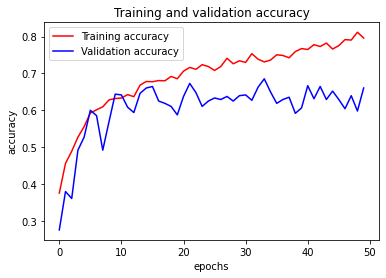

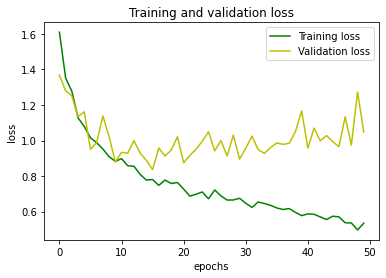

In [7]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.legend()
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.savefig(' accuracy.png')
plt.show()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.legend()
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig(' loss.png')
plt.show()

In [8]:
test_dataset = 'D:/Projects/37008/RiceDiseaseDataset/validation/'

test_datagen = ImageDataGenerator(rescale=1.0/255)


test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=32,
                                                 target_size = (180, 180),
                                                 class_mode='categorical')

Found 492 images belonging to 4 classes.


In [9]:
predictions = model.predict(test_generator)
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=32)


16/16 [==============================] - 45s 3s/step - loss: 1.0458 - accuracy: 0.6585


In [11]:
test_accuracy

0.6585366129875183

In [10]:
predictions1=model.predict(train_generator)
train_loss, train_accuracy = model.evaluate(train_generator, batch_size=32)

50/50 [==============================] - 272s 5s/step - loss: 0.4940 - accuracy: 0.8094


In [12]:
train_accuracy

0.809374988079071

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [20]:
%%time

from keras.applications.densenet import DenseNet201

LEARNING_RATE = 0.001
EPOCHS = 30
NUM_CLASSES = 4

def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = tf.keras.layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
    conv_3x3 = tf.keras.layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = tf.keras.layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    conv_5x5 = tf.keras.layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = tf.keras.layers.Conv2D(filters_5x5, (4, 4), padding='same', activation='relu')(conv_5x5)

    pool_proj = tf.keras.layers.MaxPool2D((2, 2), strides=(1, 1), padding='same')(x) # 0.902
    pool_proj = tf.keras.layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)
    # pool_proj = tf.keras.layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    # pool_proj = tf.keras.layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = tf.keras.layers.Concatenate(axis=3)([conv_1x1, conv_3x3, conv_5x5, pool_proj])
    
    return output



base_model1 = DenseNet201(weights="imagenet", include_top=False, input_shape=[180,180,3])
# base_model2 = InceptionResNetV2(weights='imagenet', include_top=False) 
                             
inputs = tf.keras.Input(shape=(180, 180, 3))

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
])


out_layer = data_augmentation(inputs)

out_layer = base_model1(out_layer)

out_layer = inception_module(out_layer,
                     filters_1x1=300,
                     filters_3x3_reduce=200,
                     filters_3x3=320,
                     filters_5x5_reduce=100,
                     filters_5x5=100,
                     filters_pool_proj=80,
                     name='inception_3a')


out_layer = tf.keras.layers.GlobalAveragePooling2D()(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)

out_layer = tf.keras.layers.Reshape((-1,80))(out_layer)
out_layer = tf.keras.layers.LSTM(80)(out_layer)

out_layer = tf.keras.layers.Dense(units=100, activation='relu')(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)


pred = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(out_layer)
model = tf.keras.models.Model(inputs=inputs, outputs=pred)

for layer in base_model1.layers[:410]:
    layer.trainable = False

 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), # decay=learning_rate/EPOCHS
              loss='categorical_crossentropy',
              metrics=["accuracy"])

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,                    
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    epochs=20)

Epoch 1/20
84/84 [==============================] - 476s 5s/step - loss: 1.1741 - accuracy: 0.5449 - val_loss: 1.3205 - val_accuracy: 0.3832
Epoch 2/20
84/84 [==============================] - 456s 5s/step - loss: 0.9138 - accuracy: 0.6644 - val_loss: 1.1696 - val_accuracy: 0.4934
Epoch 3/20
84/84 [==============================] - 451s 5s/step - loss: 0.8194 - accuracy: 0.6715 - val_loss: 1.3210 - val_accuracy: 0.4572
Epoch 4/20
84/84 [==============================] - 445s 5s/step - loss: 0.8101 - accuracy: 0.6894 - val_loss: 1.3539 - val_accuracy: 0.5082
Epoch 5/20
84/84 [==============================] - 476s 6s/step - loss: 0.7690 - accuracy: 0.6976 - val_loss: 1.3767 - val_accuracy: 0.5016
Epoch 6/20
84/84 [==============================] - 464s 6s/step - loss: 0.7463 - accuracy: 0.7199 - val_loss: 1.4215 - val_accuracy: 0.4951
Epoch 7/20
84/84 [==============================] - 500s 6s/step - loss: 0.7378 - accuracy: 0.7058 - val_loss: 1.7090 - val_accuracy: 0.4424
Epoch 8/20
84

KeyboardInterrupt: 

In [16]:
test_dataset = 'D:/Projects/37008/RiceDiseaseDataset/validation/'

test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=32,
                                                 target_size = (180, 180),
                                                 class_mode='categorical')

Found 492 images belonging to 4 classes.


In [17]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=32)

16/16 [==============================] - 26s 2s/step - loss: 1.1459 - acc: 0.5427


In [22]:
%%time

from tensorflow.keras import models
from keras.models import Sequential, load_model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.regularizers import l2

reg2=reg2=l2(1e-4)     
initializer = tf.keras.initializers.GlorotNormal()


model = models.Sequential()
model.add(Conv2D(filters=32,kernel_size=(1,1),kernel_regularizer=reg2,strides=1,padding='same',input_shape=(224,224,3)))
model.add(BatchNormalization())
#model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1,1)))

model.add(Conv2D(filters=64,kernel_size=(2,2),kernel_regularizer=reg2,strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=32,kernel_size=(2,2),kernel_regularizer=reg2,strides=1,padding='same'))
model.add(BatchNormalization())
#model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=64,kernel_size=(3,3),kernel_regularizer=reg2,strides=3,padding='same'))
#model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Reshape((-1, 128)))

model.add(LSTM(64,activation='relu'))

#model.add(MaxPooling2D(pool_size=(2, 2),strides=1))
model.add(Dense(32,Activation('relu'),kernel_initializer=initializer))

model.add(Flatten())

model.add(Dense(4, activation='softmax'))


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])

#model.summary()

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,                    
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    epochs=50)

Epoch 1/150
50/50 [==============================] - 143s 3s/step - loss: 1.3555 - acc: 0.3113 - val_loss: 1.3987 - val_acc: 0.2542
Epoch 2/150
50/50 [==============================] - 154s 3s/step - loss: 1.2227 - acc: 0.4263 - val_loss: 1.3969 - val_acc: 0.2521
Epoch 3/150
50/50 [==============================] - 139s 3s/step - loss: 1.1341 - acc: 0.4712 - val_loss: 1.3903 - val_acc: 0.2479
Epoch 4/150
50/50 [==============================] - 142s 3s/step - loss: 1.1148 - acc: 0.4894 - val_loss: 1.3785 - val_acc: 0.2500
Epoch 5/150
50/50 [==============================] - 140s 3s/step - loss: 1.1005 - acc: 0.5000 - val_loss: 1.3637 - val_acc: 0.2750
Epoch 6/150
50/50 [==============================] - 147s 3s/step - loss: 1.0852 - acc: 0.5175 - val_loss: 1.3394 - val_acc: 0.3458
Epoch 7/150
50/50 [==============================] - 147s 3s/step - loss: 1.0892 - acc: 0.5075 - val_loss: 1.3705 - val_acc: 0.3083
Epoch 8/150
50/50 [==============================] - 149s 3s/step - loss: 1.

50/50 [==============================] - 144s 3s/step - loss: 0.7230 - acc: 0.6963 - val_loss: 1.1382 - val_acc: 0.5625
Epoch 124/150
50/50 [==============================] - 142s 3s/step - loss: 0.7261 - acc: 0.7144 - val_loss: 1.1400 - val_acc: 0.5375
Epoch 125/150
50/50 [==============================] - 143s 3s/step - loss: 0.7467 - acc: 0.6944 - val_loss: 1.1273 - val_acc: 0.5458
Epoch 126/150
50/50 [==============================] - 151s 3s/step - loss: 0.7160 - acc: 0.7038 - val_loss: 1.1679 - val_acc: 0.5500
Epoch 127/150
50/50 [==============================] - 139s 3s/step - loss: 0.7370 - acc: 0.6825 - val_loss: 1.1233 - val_acc: 0.5542
Epoch 128/150
50/50 [==============================] - 144s 3s/step - loss: 0.7122 - acc: 0.7000 - val_loss: 1.1340 - val_acc: 0.5562
Epoch 129/150
50/50 [==============================] - 142s 3s/step - loss: 0.7105 - acc: 0.7119 - val_loss: 1.1834 - val_acc: 0.5250
Epoch 130/150
50/50 [==============================] - 137s 3s/step - loss: 

In [23]:
test_dataset = 'D:/Projects/37008/RiceDiseaseDataset/validation/'

test_datagen = ImageDataGenerator(rescale=1.0/255)


test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=32,
                                                 target_size = (180, 180),
                                                 class_mode='categorical')

Found 492 images belonging to 4 classes.


In [25]:
model.save("rice150.h5")

In [29]:
predictions = model.predict(test_generator)

16/16 [==============================] - 28s 2s/step


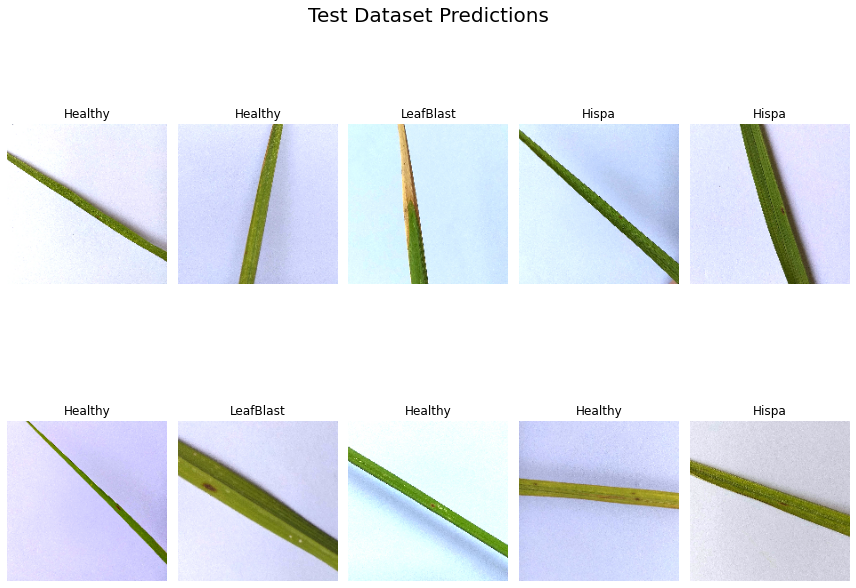

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

# Densenet

In [27]:
from keras.applications.densenet import DenseNet201

LEARNING_RATE = 0.001
EPOCHS = 30
NUM_CLASSES = 4

def cnn_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = tf.keras.layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
    conv_3x3 = tf.keras.layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = tf.keras.layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    conv_5x5 = tf.keras.layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = tf.keras.layers.Conv2D(filters_5x5, (4, 4), padding='same', activation='relu')(conv_5x5)

    pool_proj = tf.keras.layers.MaxPool2D((2, 2), strides=(1, 1), padding='same')(x) # 0.902
    pool_proj = tf.keras.layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)
    # pool_proj = tf.keras.layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    # pool_proj = tf.keras.layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = tf.keras.layers.Concatenate(axis=3)([conv_1x1, conv_3x3, conv_5x5, pool_proj])
    
    return output



base_model1 = DenseNet201(weights="imagenet", include_top=False, input_shape=[180,180,3])
# base_model2 = InceptionResNetV2(weights='imagenet', include_top=False) 
                             
inputs = tf.keras.Input(shape=(180, 180, 3))

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
])


out_layer = data_augmentation(inputs)

out_layer = base_model1(out_layer)

out_layer = cnn_module(out_layer,
                     filters_1x1=300,
                     filters_3x3_reduce=200,
                     filters_3x3=320,
                     filters_5x5_reduce=100,
                     filters_5x5=100,
                     filters_pool_proj=80,
                     name='cnn_3a')


out_layer = tf.keras.layers.GlobalAveragePooling2D()(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
out_layer = tf.keras.layers.Dense(units=100, activation='relu')(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
out_layer = tf.keras.layers.Dropout(rate=0.4)(out_layer)


pred = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(out_layer)
model = tf.keras.models.Model(inputs=inputs, outputs=pred)

for layer in base_model1.layers[:410]:
    layer.trainable = False

 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), # decay=learning_rate/EPOCHS
              loss='categorical_crossentropy',
              metrics=["accuracy"])

In [ ]:
from keras.applications.densenet import DenseNet201

LEARNING_RATE = 0.001
EPOCHS = 30
NUM_CLASSES = 4

def cnn_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = tf.keras.layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
    conv_3x3 = tf.keras.layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = tf.keras.layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    conv_5x5 = tf.keras.layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = tf.keras.layers.Conv2D(filters_5x5, (4, 4), padding='same', activation='relu')(conv_5x5)

    pool_proj = tf.keras.layers.MaxPool2D((2, 2), strides=(1, 1), padding='same')(x) # 0.902
    pool_proj = tf.keras.layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)
    # pool_proj = tf.keras.layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    # pool_proj = tf.keras.layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = tf.keras.layers.Concatenate(axis=3)([conv_1x1, conv_3x3, conv_5x5, pool_proj])
    
    return output



base_model1 = DenseNet201(weights="imagenet", include_top=False, input_shape=[180,180,3])
# base_model2 = InceptionResNetV2(weights='imagenet', include_top=False) 
                             
inputs = tf.keras.Input(shape=(180, 180, 3))

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
])


out_layer = data_augmentation(inputs)

out_layer = base_model1(out_layer)

out_layer = cnn_module(out_layer,
                     filters_1x1=300,
                     filters_3x3_reduce=200,
                     filters_3x3=320,
                     filters_5x5_reduce=100,
                     filters_5x5=100,
                     filters_pool_proj=80,
                     name='cnn_3a')


out_layer = tf.keras.layers.GlobalAveragePooling2D()(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
out_layer = tf.keras.layers.Dense(units=100, activation='relu')(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
out_layer = tf.keras.layers.Dropout(rate=0.4)(out_layer)


pred = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(out_layer)
model = tf.keras.models.Model(inputs=inputs, outputs=pred)

for layer in base_model1.layers[:410]:
    layer.trainable = False

 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), # decay=learning_rate/EPOCHS
              loss='categorical_crossentropy',
              metrics=["accuracy"])

In [16]:
%%time
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,                    
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    epochs=1)

 4/50 [=>............................] - ETA: 3:50 - loss: 1.9327 - accuracy: 0.3203

KeyboardInterrupt: 

In [27]:
test_dataset = 'D:/Projects/37008/RiceDiseaseDataset/validation/'

test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=32,
                                                 target_size = (180, 180),
                                                 class_mode='categorical')

Found 492 images belonging to 4 classes.


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=32)

print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

11/16 [===================>..........] - ETA: 14s - loss: 1.3514 - accuracy: 0.5767

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [9]:
from keras.regularizers import l2

In [26]:
def create_model():
    
    model = Sequential([ 
        
        Conv2D(filters=512, kernel_size=(2, 2), padding='same', input_shape=(180, 180, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(1, 1)),
        BatchNormalization(),
        
        Conv2D(filters=256, kernel_size=(2, 2), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(1, 1)),
        BatchNormalization(),
        
        Conv2D(filters=128, kernel_size=(2, 2), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(1, 1)),
        BatchNormalization(),
        
        Conv2D(filters=256, kernel_size=(2, 2), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(1, 1)),
        BatchNormalization(),
        
        Conv2D(filters=512, kernel_size=(2, 2), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        Dropout(0.1),
        Dense(units=4, activation='softmax')
    ])
    
    return model

In [27]:
cnn_model = create_model()
print(cnn_model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 180, 180, 512)     6656      
                                                                 
 activation_25 (Activation)  (None, 180, 180, 512)     0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 180, 180, 512)    0         
 g2D)                                                            
                                                                 
 batch_normalization_19 (Bat  (None, 180, 180, 512)    2048      
 chNormalization)                                                
                                                                 
 conv2d_34 (Conv2D)          (None, 179, 179, 256)     524544    
                                                                 
 activation_26 (Activation)  (None, 179, 179, 256)    

In [28]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
optimizer = Adam(learning_rate=0.0001)
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])


In [29]:
history = cnn_model.fit( train_generator,
                         steps_per_epoch=train_generator.samples//train_generator.batch_size,                    
                         validation_data=validation_generator,
                         validation_steps=validation_generator.samples//validation_generator.batch_size,
                         epochs=5,verbose=2,
                        callbacks=[reduce_lr])

Epoch 1/5


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_5/activation_29/Relu' defined at (most recent call last):
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2975, in run_cell
      result = self._run_cell(
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3257, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\admin\AppData\Local\Temp\ipykernel_13932\3020543073.py", line 1, in <cell line: 1>
      history = cnn_model.fit( train_generator,
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\core\activation.py", line 57, in call
      return self.activation(inputs)
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\activations.py", line 311, in relu
      return backend.relu(x, alpha=alpha, max_value=max_value, threshold=threshold)
    File "C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 4992, in relu
      x = tf.nn.relu(x)
Node: 'sequential_5/activation_29/Relu'
OOM when allocating tensor with shape[32,176,176,512] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node sequential_5/activation_29/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_78537]

In [26]:
from tensorflow.keras import models
from keras.models import Sequential, load_model
from tensorflow.keras import layers
from keras.regularizers import l2

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

model = models.Sequential()
model.add(conv_base)            # import and use ResNet50 model
model.add(layers.Flatten())


model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())

model.add(layers.Dense(4, activation='softmax'))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [28]:
%%time

history = cnn_model.fit( train_generator,
                         steps_per_epoch=train_generator.samples//train_generator.batch_size,                    
                         validation_data=validation_generator,
                         validation_steps=validation_generator.samples//validation_generator.batch_size,
                         epochs=15,verbose=2,
                        callbacks=[reduce_lr])

Epoch 1/15
50/50 - 177s - loss: 0.9847 - accuracy: 0.5594 - val_loss: 1.5250 - val_accuracy: 0.3646 - lr: 0.0010 - 177s/epoch - 4s/step
Epoch 2/15
50/50 - 173s - loss: 0.9845 - accuracy: 0.5700 - val_loss: 1.2446 - val_accuracy: 0.4333 - lr: 0.0010 - 173s/epoch - 3s/step
Epoch 3/15
50/50 - 187s - loss: 0.9746 - accuracy: 0.5738 - val_loss: 1.5187 - val_accuracy: 0.3792 - lr: 0.0010 - 187s/epoch - 4s/step
Epoch 4/15
50/50 - 175s - loss: 0.9667 - accuracy: 0.5806 - val_loss: 1.4717 - val_accuracy: 0.3229 - lr: 0.0010 - 175s/epoch - 4s/step
Epoch 5/15
50/50 - 191s - loss: 0.9717 - accuracy: 0.5713 - val_loss: 1.2861 - val_accuracy: 0.4396 - lr: 0.0010 - 191s/epoch - 4s/step
Epoch 6/15
50/50 - 210s - loss: 0.9666 - accuracy: 0.5838 - val_loss: 1.4760 - val_accuracy: 0.4313 - lr: 0.0010 - 210s/epoch - 4s/step
Epoch 7/15
50/50 - 240s - loss: 0.9553 - accuracy: 0.5856 - val_loss: 1.3595 - val_accuracy: 0.4167 - lr: 0.0010 - 240s/epoch - 5s/step
Epoch 8/15
50/50 - 194s - loss: 0.8900 - accurac

In [29]:
test_dataset = 'D:/Projects/37008/RiceDiseaseDataset/validation/'

test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=32,
                                                 target_size = (180, 180),
                                                 class_mode='categorical')

Found 492 images belonging to 4 classes.


In [30]:
predictions = cnn_model.predict(test_generator)

16/16 [==============================] - 27s 2s/step


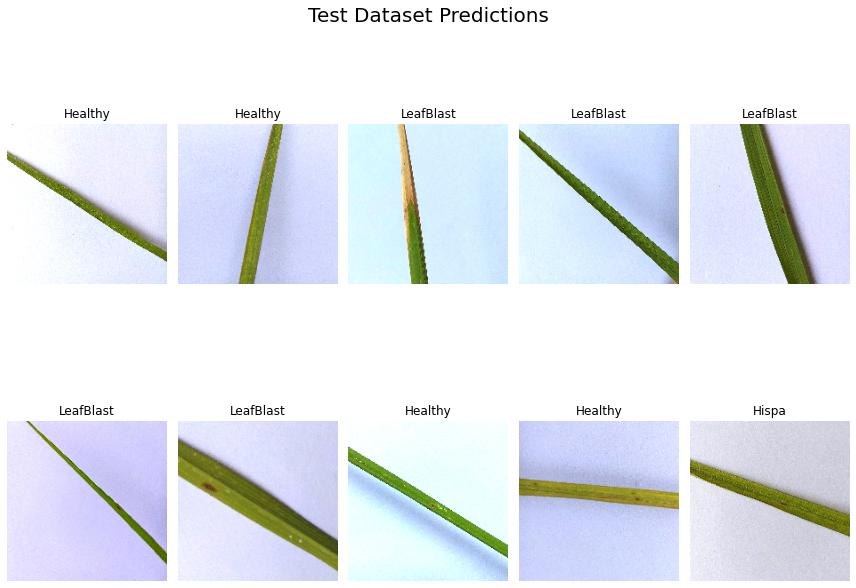

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [32]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=32)


16/16 [==============================] - 29s 2s/step - loss: 1.1215 - accuracy: 0.5081


In [33]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     1.121477723121643
Test Accuracy: 0.5081300735473633


In [34]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

In [35]:
print(classification_report(y_true, y_pred, target_names=labels.values()))


              precision    recall  f1-score   support

   BrownSpot       0.75      0.74      0.74       123
     Healthy       0.40      0.31      0.35       123
       Hispa       0.41      0.57      0.48       123
   LeafBlast       0.49      0.41      0.45       123

    accuracy                           0.51       492
   macro avg       0.51      0.51      0.50       492
weighted avg       0.51      0.51      0.50       492



In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.regularizers import l2

reg2=l2(1e-4)     
num_filters2=32
ac2='relu'
adm2=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt2=adm2
drop_dense2=0.2
drop_conv2=0.1

# Define Xavier initialization method:
initializer = tf.keras.initializers.GlorotNormal()


model = Sequential()

model.add(Conv2D(filters=128,kernel_size=2,kernel_regularizer=reg2,strides=1,padding='same',input_shape=(180,180,3)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1,1), strides=1))

model.add(Conv2D(filters=64,kernel_size=2,kernel_regularizer=reg2,strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(1,1), strides=1))

model.add(Conv2D(filters=64,kernel_size=2,kernel_regularizer=reg2,strides=1,padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1,1), strides=1))

model.add(Conv2D(filters=64,kernel_size=2,kernel_regularizer=reg2,strides=2,padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1,1), strides=1))

model.add(Conv2D(filters=64,kernel_size=2,kernel_regularizer=reg2,strides=1,padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1,1), strides=1))


model.add(Conv2D(filters=128,kernel_size=2,kernel_regularizer=reg2,strides=1,padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(128,Activation('relu')))
model.add(MaxPooling2D(pool_size=(2, 2),strides=1))


model.add(layers.Reshape((-1, 128)))   #LSTM
model.add(layers.LSTM(128))

#model.add(tf.keras.layers.Reshape((-1, 128)))
#model.add(tf.keras.layers.LSTM(64,activation='relu'))
#model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=1))
model.add(Dense(128,Activation('relu'),kernel_initializer=initializer))

model.add(Flatten())

model.add(Dense(4, activation='softmax'))


model.compile( loss=CategoricalCrossentropy(),optimizer=opt2,metrics=['categorical_accuracy'])

#model.summary()

history = model.fit( train_generator,
                     steps_per_epoch=train_generator.samples//train_generator.batch_size,                    
                     validation_data=validation_generator,
                     validation_steps=validation_generator.samples//validation_generator.batch_size,
                     epochs=3 )

# Inception+DenseNet

In [5]:
from keras.applications.densenet import DenseNet201

LEARNING_RATE = 0.001
EPOCHS = 30
NUM_CLASSES = 4

def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = tf.keras.layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
    conv_3x3 = tf.keras.layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = tf.keras.layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    conv_5x5 = tf.keras.layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = tf.keras.layers.Conv2D(filters_5x5, (4, 4), padding='same', activation='relu')(conv_5x5)

    pool_proj = tf.keras.layers.MaxPool2D((2, 2), strides=(1, 1), padding='same')(x) # 0.902
    pool_proj = tf.keras.layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)
    # pool_proj = tf.keras.layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    # pool_proj = tf.keras.layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = tf.keras.layers.Concatenate(axis=3)([conv_1x1, conv_3x3, conv_5x5, pool_proj])
    
    return output



base_model1 = DenseNet201(weights="imagenet", include_top=False, input_shape=[220,220,3])
# base_model2 = InceptionResNetV2(weights='imagenet', include_top=False) 
                             
inputs = tf.keras.Input(shape=(220, 220, 3))

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
])


out_layer = data_augmentation(inputs)

out_layer = base_model1(out_layer)

out_layer = inception_module(out_layer,
                     filters_1x1=300,
                     filters_3x3_reduce=200,
                     filters_3x3=320,
                     filters_5x5_reduce=100,
                     filters_5x5=100,
                     filters_pool_proj=80,
                     name='inception_3a')


out_layer = tf.keras.layers.GlobalAveragePooling2D()(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
out_layer = tf.keras.layers.Dense(units=100, activation='relu')(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
out_layer = tf.keras.layers.Dropout(rate=0.4)(out_layer)


pred = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(out_layer)
model = tf.keras.models.Model(inputs=inputs, outputs=pred)

for layer in base_model1.layers[:410]:
    layer.trainable = False

 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), # decay=learning_rate/EPOCHS
              loss='categorical_crossentropy',
              metrics=["accuracy"])

In [6]:
%%time
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,                    
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    epochs=50)

Epoch 1/50
50/50 [==============================] - 368s 7s/step - loss: 1.6588 - accuracy: 0.4137 - val_loss: 5.0697 - val_accuracy: 0.3938
Epoch 2/50
50/50 [==============================] - 395s 8s/step - loss: 1.2148 - accuracy: 0.5375 - val_loss: 2.2155 - val_accuracy: 0.4646
Epoch 3/50
50/50 [==============================] - 370s 7s/step - loss: 1.0436 - accuracy: 0.5950 - val_loss: 1.3496 - val_accuracy: 0.6271
Epoch 4/50
50/50 [==============================] - 370s 7s/step - loss: 0.9516 - accuracy: 0.6294 - val_loss: 1.1814 - val_accuracy: 0.6625
Epoch 5/50
50/50 [==============================] - 362s 7s/step - loss: 0.9203 - accuracy: 0.6156 - val_loss: 1.3068 - val_accuracy: 0.5771
Epoch 6/50
50/50 [==============================] - 359s 7s/step - loss: 0.8945 - accuracy: 0.6425 - val_loss: 1.0288 - val_accuracy: 0.5979
Epoch 7/50
50/50 [==============================] - 364s 7s/step - loss: 0.8351 - accuracy: 0.6556 - val_loss: 1.1201 - val_accuracy: 0.6167
Epoch 8/50
50

# CNN

In [6]:
model = Sequential()


# 1st Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=(3,3),padding="Same",activation="relu" , input_shape = (220,220,3)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
# 2nd Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=(3,3),padding="Same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
# 3rd Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=(3,3),padding="Same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
# 4th Convolutional Layer
model.add(Conv2D(filters=32,kernel_size = (3,3),padding="Same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
# 5th Convolutional Layer
model.add(Conv2D(filters=64,kernel_size = (3,3),padding="Same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# 6th Convolutional Layer
model.add(Conv2D(filters=32,kernel_size = (3,3),padding="Same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# 7th Convolutional Layer
model.add(Conv2D(filters=64,kernel_size = (3,3),padding="Same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))



# 1st Fully Connected Layer
model.add(Dense(32,activation="relu"))
model.add(Dropout(0.1))
model.add(BatchNormalization())


model.add(Flatten())

# Add output layer
model.add(Dense(4,activation="softmax"))

#model.summary() # print summary my model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 110, 110, 32)     128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 110, 110, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 64)       0

In [10]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001),metrics=['categorical_accuracy']) #optimizer='adam'


history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=5,                 
                    verbose=2)

Epoch 1/5
50/50 - 172s - loss: 1.3889 - categorical_accuracy: 0.4225 - val_loss: 1.4713 - val_categorical_accuracy: 0.2500 - 172s/epoch - 3s/step
Epoch 2/5
50/50 - 163s - loss: 1.2502 - categorical_accuracy: 0.4444 - val_loss: 1.6131 - val_categorical_accuracy: 0.2520 - 163s/epoch - 3s/step
Epoch 3/5
50/50 - 165s - loss: 1.1925 - categorical_accuracy: 0.4613 - val_loss: 1.5909 - val_categorical_accuracy: 0.2846 - 165s/epoch - 3s/step
Epoch 4/5
50/50 - 165s - loss: 1.1320 - categorical_accuracy: 0.4950 - val_loss: 1.5245 - val_categorical_accuracy: 0.2378 - 165s/epoch - 3s/step
Epoch 5/5
50/50 - 166s - loss: 1.1444 - categorical_accuracy: 0.4869 - val_loss: 1.5198 - val_categorical_accuracy: 0.2947 - 166s/epoch - 3s/step


# CNN+LSTM

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.regularizers import l2

reg2=l2(1e-4)     
num_filters2=32
ac2='relu'
adm2=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt2=adm2
drop_dense2=0.2
drop_conv2=0.1

# Define Xavier initialization method:
initializer = tf.keras.initializers.GlorotNormal()
reg2=reg2=l2(1e-4)     
initializer = tf.keras.initializers.GlorotNormal()


model = Sequential()

model.add(Conv2D(filters=232,kernel_size=3,kernel_regularizer=reg2,strides=1,padding='same',input_shape=(220,220,3)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(132,Activation('relu')))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(filters=164,kernel_size=3,kernel_regularizer=reg2,strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(164,Activation('relu')))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(filters=128,kernel_size=3,kernel_regularizer=reg2,strides=1,padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(128,Activation('relu')))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(filters=128,kernel_size=3,kernel_regularizer=reg2,strides=2,padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(128,Activation('relu')))
model.add(MaxPooling2D(pool_size=(2,2), strides=1))

model.add(Conv2D(filters=64,kernel_size=3,kernel_regularizer=reg2,strides=1,padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(64,Activation('relu')))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))


model.add(Conv2D(filters=132,kernel_size=3,kernel_regularizer=reg2,strides=1,padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(128,Activation('relu')))
model.add(MaxPooling2D(pool_size=(2, 2),strides=1))



model.add(Reshape((-1, 128)))
model.add(LSTM(256,activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2),strides=1))
model.add(Dense(64,Activation('relu'),kernel_initializer=initializer))

model.add(Flatten())

model.add(Dense(4, activation='softmax'))


model.compile( loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])

#model.summary()

C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
tf.keras.utils.plot_model(model, to_file="model.png")

In [7]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,                    
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    epochs=10 )

Epoch 1/10
50/50 [==============================] - 939s 19s/step - loss: 1.3428 - accuracy: 0.3638 - val_loss: 1.4310 - val_accuracy: 0.3036
Epoch 2/10
50/50 [==============================] - 926s 18s/step - loss: 1.2451 - accuracy: 0.4319 - val_loss: 1.4942 - val_accuracy: 0.2634
Epoch 3/10
50/50 [==============================] - 928s 19s/step - loss: 1.1940 - accuracy: 0.4531 - val_loss: 1.3494 - val_accuracy: 0.3013
Epoch 4/10
50/50 [==============================] - 864s 17s/step - loss: 1.1749 - accuracy: 0.4812 - val_loss: 1.5854 - val_accuracy: 0.2500
Epoch 5/10
50/50 [==============================] - 854s 17s/step - loss: 1.1702 - accuracy: 0.4894 - val_loss: 1.3383 - val_accuracy: 0.2857
Epoch 6/10
50/50 [==============================] - 1835s 37s/step - loss: 1.1650 - accuracy: 0.4931 - val_loss: 1.4382 - val_accuracy: 0.2768
Epoch 7/10
50/50 [==============================] - 964s 19s/step - loss: 1.1609 - accuracy: 0.4744 - val_loss: 1.4218 - val_accuracy: 0.2634
Epoch

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras import models
from keras.models import Sequential, load_model

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(220, 220, 3))

model = models.Sequential()
model.add(conv_base)            # import and use ResNet50 model
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer=opt2, loss='categorical_crossentropy', metrics=['acc'])

# Transfer Learning_RESNET50

In [51]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(180, 180, 3))



In [52]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_25[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 45, 45, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 45, 45, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 45, 45, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 45, 45, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 23, 23, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 23, 23, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 23, 23, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 23, 23, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_1_relu (Activatio  (None, 12, 12, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 12, 12, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 12, 12, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 12, 12, 256)  0          ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 12, 12, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 12, 12, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 12, 12, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 12, 12, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)       

 conv5_block2_1_conv (Conv2D)   (None, 6, 6, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 6, 6, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 6, 6, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 6, 6, 512)    2359808     ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_blo

In [53]:
from tensorflow.keras import models
from keras.models import Sequential, load_model

In [67]:
model = models.Sequential()
model.add(conv_base)            # import and use ResNet50 model
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())
model.add(layers.Dense(4, activation='softmax'))

model.compile(optimizer=opt2, loss='categorical_crossentropy', metrics=['acc'])

In [31]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_6 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization_71 (Bat  (None, 100352)           401408    
 chNormalization)                                                
                                                                 
 dense_71 (Dense)            (None, 128)               12845184  
                                                                 
 dropout_63 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_72 (Bat  (None, 128)              512       
 chNormalization)                                    

In [32]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,                    
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    epochs=10 ) 

Epoch 1/10
50/50 [==============================] - 527s 10s/step - loss: 1.6346 - acc: 0.3394 - val_loss: 337730.4375 - val_acc: 0.2567
Epoch 2/10
50/50 [==============================] - 554s 11s/step - loss: 1.3602 - acc: 0.3919 - val_loss: 1.7078 - val_acc: 0.2522
Epoch 3/10
40/50 [=======================>......] - ETA: 1:30 - loss: 1.3049 - acc: 0.3938

KeyboardInterrupt: 